1. Import Libraries

In [1]:
import pandas as pd
import numpy as np
import os
import json
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-v0_8-darkgrid')

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer


from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

import joblib

2. Load and Explore Dataset

In [2]:
df = pd.read_csv("heart_disease_dataset_CHUD_S_A.csv")

print("Dataset Shape:", df.shape)
df.head()

Dataset Shape: (5000, 14)


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,heart_disease
0,38.871687,Male,Typical Angina,100.490248,163.166661,NaN,LV hypertrophy,183.658119,No,0.114644,Upsloping,0.0,Normal,no disease
1,60.625755,Male,Asymptomatic,NaN,338.711395,True,LV hypertrophy,141.161921,NaN,2.361526,Downsloping,2.0,NaN,severe
2,64.306898,Male,NaN,146.355656,337.004035,True,LV hypertrophy,NaN,Yes,2.660477,Downsloping,2.0,Reversible defect,severe
3,57.457313,Female,Non-Anginal Pain,NaN,260.116075,True,NaN,150.353969,Yes,1.145959,Flat,1.0,Reversible defect,mild
4,53.394739,Male,Non-Anginal Pain,129.763455,224.948879,False,LV hypertrophy,147.834030,Yes,NaN,Flat,NaN,Reversible defect,mild


3. Data Overview and Information

In [3]:
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   age            4411 non-null   float64
 1   sex            4418 non-null   object 
 2   cp             4409 non-null   object 
 3   trestbps       4399 non-null   float64
 4   chol           4425 non-null   float64
 5   fbs            4421 non-null   object 
 6   restecg        4417 non-null   object 
 7   thalach        4416 non-null   float64
 8   exang          4405 non-null   object 
 9   oldpeak        4407 non-null   float64
 10  slope          4402 non-null   object 
 11  ca             4411 non-null   float64
 12  thal           4399 non-null   object 
 13  heart_disease  5000 non-null   object 
dtypes: float64(6), object(8)
memory usage: 547.0+ KB


,age,trestbps,chol,thalach,oldpeak,ca
count,4411.000000,4399.000000,4425.000000,4416.000000,4407.000000,4411.000000
mean,54.829901,133.019682,262.883223,150.289463,1.778127,1.378372
std,10.855032,19.913154,80.613567,22.141853,1.581597,1.022590
min,29.000000,94.000000,126.000000,101.383435,0.000000,0.000000
25%,46.027138,116.479869,188.967414,131.642083,0.485799,1.000000
50%,54.822873,134.500404,259.801646,149.953070,1.191017,1.000000
75%,63.539473,148.299363,327.875962,169.124221,2.626216,2.000000
max,77.000000,176.782096,423.482009,195.551682,5.165494,3.000000


4. Missing Values Analysis

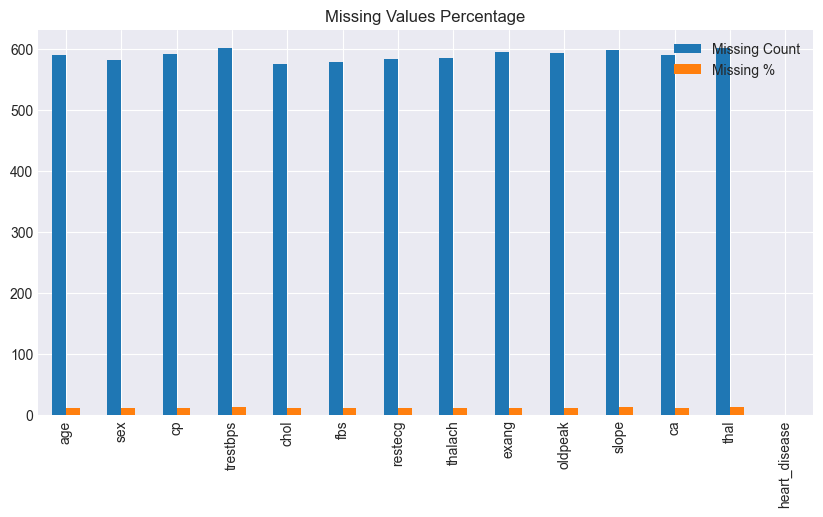

In [4]:
missing = df.isnull().sum()
missing_percent = (missing / len(df)) * 100

missing_df = pd.DataFrame({
    "Missing Count": missing,
    "Missing %": missing_percent
})

missing_df[missing_df["Missing Count"] > 0]


missing_df.plot(kind="bar", figsize=(10,5), title="Missing Values Percentage")
plt.show()


5. TARGET DISTRIBUTION

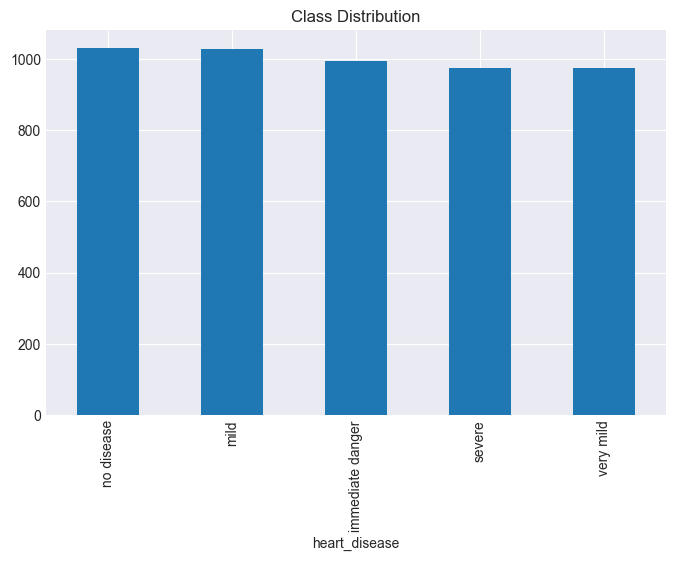

heart_disease
no disease          20.60
mild                20.56
immediate danger    19.88
severe              19.48
very mild           19.48
Name: proportion, dtype: float64

In [5]:
target_col = "heart_disease"

df[target_col].value_counts().plot(
    kind="bar", figsize=(8,5),
    title="Class Distribution"
)
plt.show()



df[target_col].value_counts(normalize=True) * 100

6. FEATURE TYPES

In [6]:
target_col = "heart_disease"

X = df.drop(columns=[target_col])
y = df[target_col]

numerical_features = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
categorical_features = X.select_dtypes(include=["object", "category", "bool"]).columns.tolist()

print("Numerical features:", numerical_features)
print("Categorical features:", categorical_features)

Numerical features: ['age', 'trestbps', 'chol', 'thalach', 'oldpeak', 'ca']
Categorical features: ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'thal']


7. Outlier Detection and Analysis

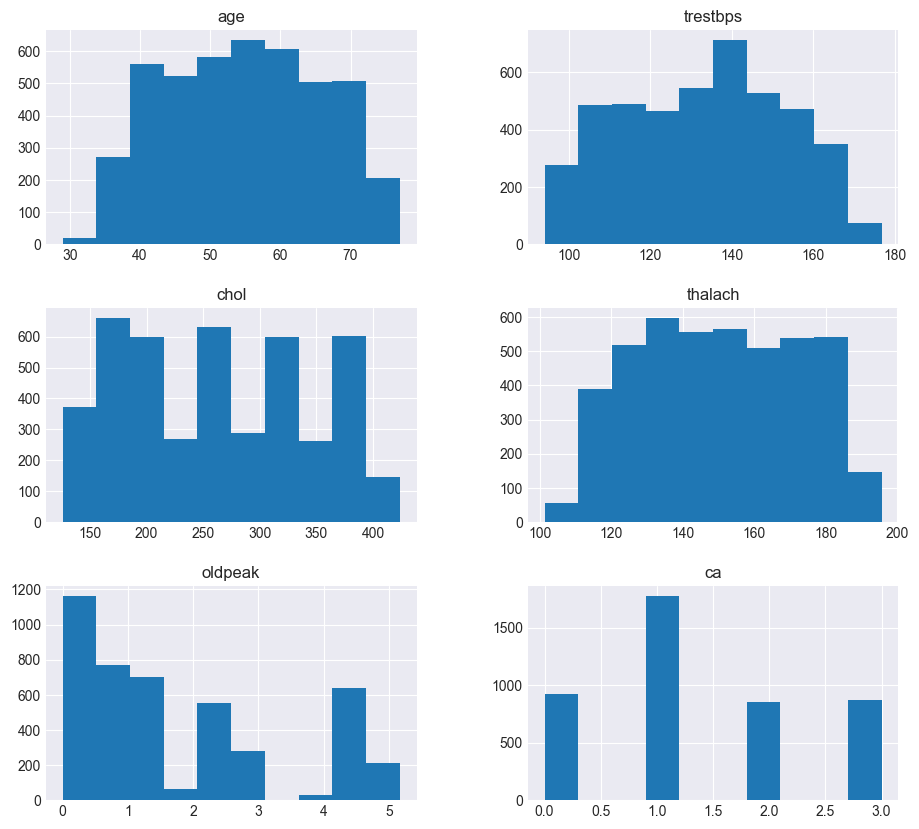

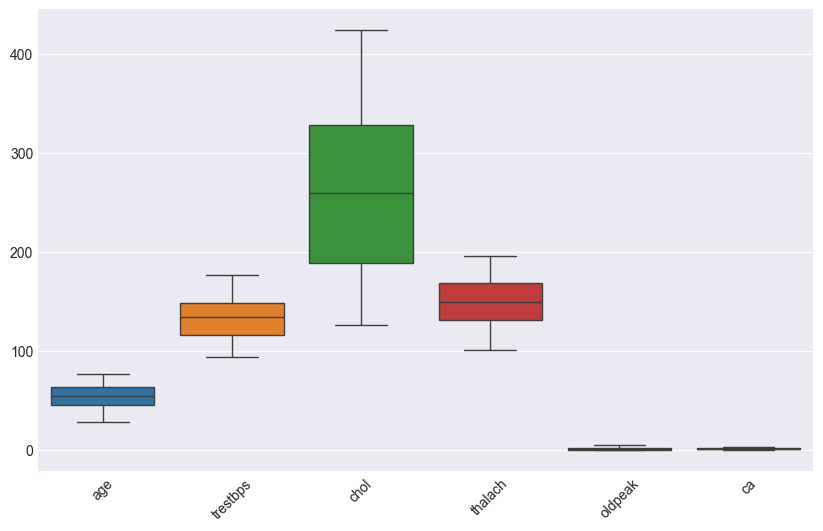

In [7]:
df[numerical_features].hist(figsize=(11,10))
plt.show()


plt.figure(figsize=(10,6))
sns.boxplot(data=df[numerical_features])
plt.xticks(rotation=45)
plt.show()

8. target encoding

In [8]:
label_encoder = LabelEncoder()
df["target_encoded"] = label_encoder.fit_transform(df[target_col])

class_labels = label_encoder.classes_.tolist()

print("Class mapping:")
for i, cls in enumerate(class_labels):
    print(f"{i} → {cls}")

Class mapping:
0 → immediate danger
1 → mild
2 → no disease
3 → severe
4 → very mild


9. Feature/target split

In [9]:
X = df.drop(["heart_disease", "target_encoded"], axis=1)
y = df["target_encoded"]

10. preprocessing pipeline

In [10]:
num_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

cat_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer([
    ("num", num_pipe, numerical_features),
    ("cat", cat_pipe, categorical_features)
])


11.  Train-Test Split Stratified

In [11]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

12. model definition

In [12]:
models = {
    "Random Forest": RandomForestClassifier(random_state=42),
    "SVM": SVC(probability=True),
    "KNN": KNeighborsClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "MLP": MLPClassifier(max_iter=1000)
}

13. trainig and compare

In [13]:
results = {}

for name, model in models.items():
    pipe = Pipeline([
        ("prep", preprocessor),
        ("clf", model)
    ])
    
    pipe.fit(X_train, y_train)
    
    train_acc = accuracy_score(y_train, pipe.predict(X_train))
    test_acc = accuracy_score(y_test, pipe.predict(X_test))
    
    results[name] = (train_acc, test_acc)


results_df = pd.DataFrame(results, index=["Train Acc", "Test Acc"]).T
results_df


,Train Acc,Test Acc
Random Forest,1.00000,0.999
SVM,0.99875,0.997
KNN,0.99525,0.989
Gradient Boosting,1.00000,0.999
MLP,0.99950,0.998


14. model selection

In [14]:
best_model_name = results_df["Test Acc"].idxmax()
best_model_name


'Random Forest'

15. DETAILED EVALUATION

                  precision    recall  f1-score   support

immediate danger       1.00      0.99      1.00       199
            mild       1.00      1.00      1.00       205
      no disease       1.00      1.00      1.00       206
          severe       0.99      1.00      1.00       195
       very mild       1.00      1.00      1.00       195

        accuracy                           1.00      1000
       macro avg       1.00      1.00      1.00      1000
    weighted avg       1.00      1.00      1.00      1000



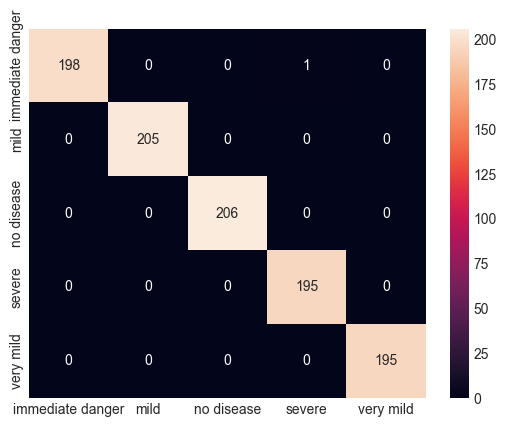

In [15]:
best_pipeline = Pipeline([
    ("prep", preprocessor),
    ("clf", models[best_model_name])
])

best_pipeline.fit(X_train, y_train)

y_pred = best_pipeline.predict(X_test)


print(classification_report(y_test, y_pred, target_names=class_labels))


sns.heatmap(confusion_matrix(y_test, y_pred),
            annot=True, fmt="d",
            xticklabels=class_labels,
            yticklabels=class_labels)
plt.show()


16. CLINICAL INTERPRETATION

- Class 0: Avoid false negatives (missed disease)
- Class 1–2: Early intervention
- Class 3–4: High recall critical – immediate care required

17. SAVE ARTIFACTS


In [16]:
os.makedirs("deployment", exist_ok=True)

joblib.dump(best_pipeline, "deployment/best_model.pkl")

with open("deployment/class_names.json", "w") as f:
    json.dump(class_labels, f)

joblib.dump(label_encoder, "deployment/label_encoder.pkl")



['deployment/label_encoder.pkl']